In [158]:
#!pip install keras
#!pip install tensorflow
#!pip install gensim
#!pip install preprocessor
import numpy as np
print(np.__version__)
#!pip install numpy==1.16.1

1.16.1


In [415]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import os
from time import time
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models as md
from keras import layers
import gensim
from gensim import corpora, models, similarities
import preprocessor as p
import os
#cancel diplay tensorflow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'




#Function to train a multi-class model
def deep_model(model, X_train, y_train, X_valid, y_valid):
  
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

#function to display the evaluation metric
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
#funcion to test the model
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results


In [441]:

tweet = pd.read_pickle('../data/final/NotIot_clean_FR_tweets_polarity.p')
len(tweet)
#tweet['sentiment'][tweet['sentiment']=='SURPRISE_POSITIVE']= "SURPRISE"
#tweet['sentiment'][tweet['sentiment']=='SURPRISE_NEGATIVE']= "SURPRISE"
#tweet['sentiment'][tweet['sentiment']=='DERANGEMENT']= "MEPRIS"
#tweet['sentiment'][tweet['sentiment']=='INSATISFACTION']= "TRISTESSE"

#tweet['clean_text'].groupby([tweet.sentiment]).count().plot(kind='bar')
tweet['sentiment'].values

array(['negative', 'negative', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

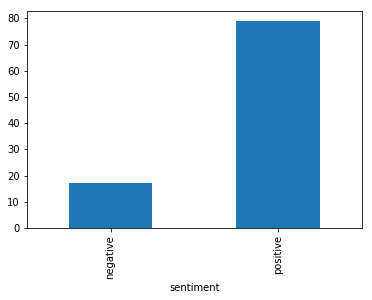

In [442]:
sondage = pd.read_pickle('../data/final/sondage_polarity_clean.p')

#sondage['sentiment'][sondage['sentiment']=='PEUR']= "peur"
#sondage['sentiment'][sondage['sentiment']=='COLERE']= "colère"
#sondage['sentiment'][sondage['sentiment']=='APAISEMENT']= "joie"
#sondage['sentiment'][sondage['sentiment']=='AMOUR']= "joie"
#sondage['sentiment'][sondage['sentiment']=='PLAISIR']= "joie"
#sondage['sentiment'][sondage['sentiment']=='MEPRIS']= "dégoûter"
#sondage['sentiment'][sondage['sentiment']=='ENNUI']= "dégoûter"
#sondage['sentiment'][sondage['sentiment']=='SURPRISE']= "surprise"

sondage['clean_text'].groupby([sondage.sentiment]).count().plot(kind='bar')


In [443]:
tweet = tweet[['clean_text', 'sentiment']]
#spliting train-test
X_train, X_test, y_train, y_test = train_test_split(tweet.clean_text, tweet.sentiment, test_size=0.1, random_state=37)

X_sond = sondage['clean_text']
y_sond = sondage['sentiment']

In [444]:
NB_WORDS = 1000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 5  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 50 # Maximum number of words in a sequence
REG = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [445]:
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
print('# sondage data samples:', X_sond.shape[0])

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_sond.shape[0] == y_sond.shape[0]

# Train data samples: 3987
# Test data samples: 443
# sondage data samples: 96


In [446]:
#tokenize tweet text
tk = Tokenizer(num_words=NB_WORDS,lower=True, split=" ")
tk.fit_on_texts(X_train)
word_index = tk.word_index
#convert text into sequence
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

X_sond_seq = tk.texts_to_sequences(X_sond)
#normalise the length of each sequence
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
print(seq_lengths.describe())

count    3987.000000
mean     9.277402   
std      2.604330   
min      2.000000   
25%      7.000000   
50%      9.000000   
75%      11.000000  
max      20.000000  
Name: clean_text, dtype: float64


In [447]:
#MAX_LEN = 1000
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)
X_sond_seq_trunc = pad_sequences(X_sond_seq, maxlen=MAX_LEN)

In [448]:
#convert sentiment to sequence
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_sond_le = le.transform(y_sond)

y_train_oh = to_categorical(y_train_le)
print(y_train_oh.shape)
y_test_oh = to_categorical(y_test_le)
print(y_test_oh.shape)
y_sond_oh = to_categorical(y_sond_le, num_classes=2)
#print(y_sond_oh.shape)

(3987, 2)
(443, 2)


In [449]:
#split off the validation data
X_train_emb, X_valid_emb, y_train_emb,y_valid_emb = train_test_split(X_train_seq_trunc,
                               y_train_oh, 
                               test_size=0.33, 
                               random_state=37)
assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

In [451]:
from keras.layers import Embedding

MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 200
embeddings_index = {}
f = open('data/glove.6B.200d.txt',  encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

Found 400000 word vectors.


In [452]:
print('Shape of validation set:',X_valid_emb.shape)
from keras.layers import Embedding, LSTM, Dense, Dropout


Shape of validation set: (1316, 50)


In [453]:
#creation of sequential keras model
emb_model = md.Sequential()
emb_model.add(embedding_layer)
emb_model.add(LSTM(100))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 200)           2311800   
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 202       
Total params: 2,432,402
Trainable params: 2,432,402
Non-trainable params: 0
_________________________________________________________________


In [454]:
emb_history = deep_model(emb_model,X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [455]:
print(emb_history.history['acc'][-1])

0.8903032575640862


In [456]:
import numpy as np
print(y_sond_oh.shape)
results = emb_model.evaluate(X_sond_seq_trunc, y_sond_oh)

(96, 2)
96/96 [==============================] - 1s 7ms/step


In [457]:
results

[0.9782548348108927, 0.625]

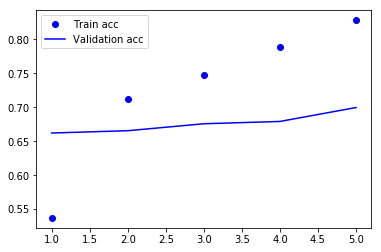

None


In [436]:
print(eval_metric(emb_history, 'acc'))

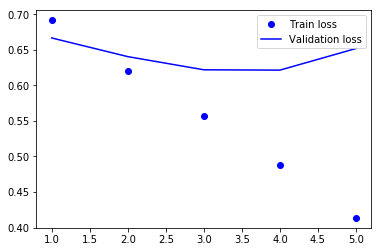

None


In [437]:
print(eval_metric(emb_history, 'loss'))

In [438]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)

99/99 [==============================] - 1s 9ms/step


In [439]:
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

Test accuracy of word embeddings model: 68.69%


In [440]:
print('Test accuracy of word embeddings model: {0:.2f}'.format(emb_results[1]))

Test accuracy of word embeddings model: 0.69


In [153]:
def save_model(model, filename):

    model_json = model.to_json()
    with open(filename + '.model', "w+") as json_file:
        json_file.write(model_json)
        json_file.close();
    model.save_weights(filename + ".weights")


def load_model(filename):

    json_file = open(filename + '.model', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".weights")

    return loaded_model;

In [154]:
save_model(emb_model,"model/model_FR_tweets_preTemb")

In [157]:
from keras.models import model_from_json

model = load_model("model/model_FR_news_preTemb")

KeyboardInterrupt: 

In [ ]:
model